In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import scipy.stats as sp


from _functions import * #includes constants and score function

import scipy.stats as stats # for t-test

import seaborn as sns


In [2]:
ls /jukebox/norman/rmasis/clones/SchemaBigFiles/

atlas_percept_score/                  Rubrics_CB/
Brainmaps/                            Rubrics_RM/
LOGS/                                 sl_percept_bumps_and_predictions/
New Folder With Items/                sl_percept_score/
roi_percept_bumps_and_predictions/    sl_percept_score_model_comparisons/
roi_percept_score/                    sl_percept_score_predictions/
roi_percept_score_backup_20210928/    SL_percept_score_predictions/
roi_percept_score_model_comparisons/  sl_percept_scores/
roi_percept_score_predictions/        sl_recall_bumps_and_predictions/
roi_recall_bumps_and_predictions/     sl_recall_score/
roi_recall_score/                     sl_recall_score_model_comparisons/
roi_recall_score_predictions/         sl_recall_score_predictions/
ROIs/


## Import rubrics as dataframes

In [5]:
stories = ['Brazil',  'Derek', 'MrBean',   'PulpFiction',
           'BigBang', 'Santa', 'Shame',    'Vinny',
           'DueDate', 'GLC',   'KandD',    'Nonstop',
           'Friends', 'HIMYM', 'Seinfeld', 'UpInTheAir']

### rubrics were graded independently by two graders
graders = ['CB', 'RM']
paths = ['../_data/Rubrics/Rubrics_CB',
        '../_data/Rubrics/Rubrics_RM']

#sort by name and keep only excel sheets
cb = np.sort([os.listdir(paths[0])[i] for i in range(len(os.listdir(paths[0]))) if 'xlsx' in os.listdir(paths[0])[i]])
rm = np.sort([os.listdir(paths[1])[i] for i in range(len(os.listdir(paths[1]))) if 'xlsx' in os.listdir(paths[1])[i]])

#ignore any possible files at the end of the sorted list (sometimes temp files are made by different OS's)
cb = cb[:len(stories)] 
rm = rm[:len(stories)]

rubrics = {'CB':{}, 'RM':{}}
for i,(c,r) in enumerate(zip(cb,rm)):
    
    ### import CB, and remove subject 6 because we don't have recall info for that subject
    rubrics['CB'][stories[i]] = pd.ExcelFile(os.path.join(paths[0],c)).parse('Sheet1')
    rubrics['CB'][stories[i]] = rubrics['CB'][stories[i]].drop([6], axis=1) 
    rubrics['CB'][stories[i]].rename(columns={'Unnamed: 0':'descrip'},inplace=True) #rename column for ease of use
    
    ### import RM rubric grading
    rubrics['RM'][stories[i]] = pd.ExcelFile(os.path.join(paths[1],r)).parse('Sheet1')
    rubrics['RM'][stories[i]].rename(columns={'Unnamed: 0':'descrip'},inplace=True) #rename column for ease of use
           
###
### constants
###

subj_initials = list(rubrics['RM'][stories[0]].keys()[1:])
indeces = np.arange(rubrics['RM'][stories[0]].values.shape[0]) #
nSubj = len(subj_initials)
nStories = len(stories)

In [4]:
rm

array(['00_BrazilRubric_save.xlsx', '01_DerekRubric.xlsx',
       '02_MrBeanRubric.xlsx', '03_PulpFictionRubric.xlsx',
       '04_BigBangRubric.xlsx', '05_TheSantaClauseRubric.xlsx',
       '06_ShameRubric.xlsx', '07_MyVinnyRubric.xlsx',
       '08_DueDateRubric.xlsx', '09_GoodLuckChuckRubric.xlsx',
       '10_KnightandDRubric.xlsx', '11_NonstopRubric.xlsx',
       '12_FriendsRubric.xlsx', '13_HowIMYMRubric.xlsx',
       '14_SeinfeldRubric.xlsx', '15_UpInTheAirRubric.xlsx'], dtype='<U28')

## total possible rubric score

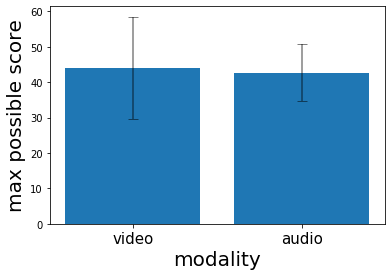

In [6]:
## max-points per story per schematic event
rubricMaxSubScores = np.array( 
       [[12. ,  5. , 16. , 15. ], #brazil
       [10. , 32. , 18. ,  7. ],  #derek
       [ 2. ,  8. , 16. ,  6. ],  #mrbean
       [11. ,  5,   30. ,  3. ],  #pulp
       [ 4. ,  3. , 30. ,  3. ],  #bigbang
       [16. ,  7. , 24. ,  3. ],  #Santa
       [ 5. , 29. , 14. , 10. ],  #shame
       [ 4. ,  9. , 23. ,  7. ],  #Vinny
       [15. , 25. ,  2. , 17. ],  #DueDate
       [ 2. , 19. ,  4. , 20. ],  #GLC
       [ 8. ,  5. , 11. ,  9. ],  #KandD
       [ 4. ,  6. ,  3. ,  6. ],  #Nonstop
       [ 5. , 19. , 10. ,  7. ],  #Friends
       [ 7. , 24. ,  4. ,  8. ],  #HIMYM
       [ 6. ,  8. ,  3. , 11. ],  #Seinfeld
       [ 4. , 19. ,  8. ,  8. ]]) #UpInTheAir

v_bool = [mod == 'V' for mod in modality] #trues where modality was video

v_mean, v_std = rubricMaxSubScores.sum(1)[v_bool].mean(0),rubricMaxSubScores.sum(1)[v_bool].std(0)
a_mean, a_std = rubricMaxSubScores.sum(1)[np.invert(v_bool)].mean(0),rubricMaxSubScores.sum(1)[np.invert(v_bool)].std(0)

x = [0,1]
y = [v_mean,a_mean]
y_err = [v_std,a_std]

plt.figure()
plt.bar(x,y)
plt.errorbar(x=x,y=y,yerr=y_err,alpha=0.5, ecolor='black', capsize=5,ls='none')
plt.xticks([0,1], ['video', 'audio'], fontsize=15)
plt.xlabel('modality',fontsize=20); 
plt.ylabel('max possible score',fontsize=20);

no difference in possible max scores between stories

In [7]:
stats.ttest_ind(rubricMaxSubScores.sum(1)[:8],rubricMaxSubScores.sum(1)[8:])

Ttest_indResult(statistic=1.7542365260297044, pvalue=0.10124243389515097)

### calculate how well subjects remembered episodic details by rubric

In [9]:
## every two columns is the start and end row in excel sheet of subevent 
rubric_events = np.array([
    [18,41,  44,53,   56,87,    90,119],    #Brazil
    [13,32,  35,98,   101,136,  139,152],   #Derek
    [13,16,  19,34,   37,68,    71,82],     #Mr Bean
    [16,37,  40,49,   52,111,   114,119],   #pulp fiction
    [11,14,  17,19,   22,51,    54,56],     #BigBang
    [11,26,  29,35,   38,61,    64,66],     #Santa
    [11,15,  18,46,   49,62,    65,74],     #Shame
    [11,14,  17,25,   28,50,    53,59],     #Vinny
    [13,42,  45,94,   97,100,   103,136],   #DueDate
    [14,17,  20,57,   60,67,    70,109],    #GLC
    [13,28,  31,40,   43,64,    67,84],     #KandD
    [14,21,  24,35,   38,43,    46,57],     #Nonstop
    [11,15,  18,36,   39,48,    51,57],     #Friends
    [11,17,  20,43,   46,49,    52,59],     #How I met
    [11,16,  19,26,   29,31,    34,44],     #Seinfeld
    [11,14,  17,35,   38,45,    48,55]])    #Up

## some re-indexing to get dataframe oriented to correct spots
rubric_events[:,::2] = rubric_events[:,::2] - 2
rubric_events[:,1::2] = rubric_events[:,1::2] - 1

In [29]:
nSubj = 30
nStories = 16
nEvents = 4
nGraders = 2

final_by_event = np.zeros((nSubj,nStories,nEvents))
final_by_story = np.zeros((nSubj,nStories))
all_scores = np.zeros((nGraders,nSubj,nStories))

details = []
detail_scores = []

temp = []
for st,story in enumerate(stories):
    
#     print("STORY: ", story)
    
    ## average by story (from both graders for final score of episodic details remembered )
    final_by_story[:,st] = (rubrics['CB'][story].values[-1,1:] + rubrics['RM'][story].values[-1,1:]) / 2
    
    event = 0
    for ev in range(nEvents):
        start = rubric_events[st,event]
        end = rubric_events[st,event+1]
        event+=2

        ## average by subevent
        subevent_cb = np.sum(~np.isnan(rubrics['CB'][story].values[start:end,1:].astype(float)),axis=0)
        subevent_rm = np.sum(~np.isnan(rubrics['RM'][story].values[start:end,1:].astype(float)),axis=0)
        final_by_event[:,st,ev] = (subevent_cb + subevent_rm)/2
        
        all_scores[0,:,st] = subevent_cb ; all_scores[1,:,st] = subevent_rm

        print('... EVENT: ', ev + 1)

        ### for a detail remembered in video story rubrics, concatenate the two rows (representing a single detail) 
        ### from the original excel file
        if modality[st] == 'V':
            for i in np.arange(start,end-1)[::2]:
                details = rubrics['RM'][story].values[i:i+2,0] 
                details = [string for string in details if str(string) !='nan']# cleanedList = [x for x in countries if str(x) != 'nan']
                print(details)
                print(' ')
        else:
            for i in np.arange(start,end):
                details = rubrics['RM'][story].values[i,0] 
                print(details)
                print(' ')
                
                
## normalize scores by max possible points
########

# rubric_norm_event = final_by_event / rubricMaxSubScores # normalize by max possible score for an event
rubric_norm_story = final_by_story / rubricMaxSubScores.sum(1) #normalize by total max possible score for a story

## SAVE
saveObject("normalizedRubricScores_byStory.pkl", rubric_norm_story)


... EVENT:  1
['Madam Lowry, you look exquisite today. Merry Xmas', "without looking back, host (spiro) recognizes madam lowry's cough signaling host's attention and he pulls aside the velvet rope with a grand flourish."]
 
['Hello Spiro. Merry Xmas.', "Lowry walks in and Spiro blocks off Lowry's son from entering."]
 
['You remember Samuel, my son', 'Lowry speaks without looking back at Spiro blocking off her son.']
 
['OH but of course…', 'Spiro realizes and stops bloccking of Sam']
 
["We're joining Mrs. Terrain.", 'Still not looking back Lowry speaks saying they are here to meet with Mrs. Terrain.']
 
['Are we?', 'Sam asks confused…']
 
['The host starts to lead them past the entrance of the establishment with Sam and his mother following. We get a peak of what the interior of this restaurant looks like. Metal tubes, Marble columns.. Very sophisticated looking place.']
 
['Mother, I thought we were going to be able to talk…', 'As they are being led to their table Sam asks disappoin

... EVENT:  1
['Diaz drags her carry-on unto the electric staircase']
 
['Cruise with sunglasses, stares from the second floor at Diaz as she goes up the escalator ']
 
['Diaz lifts up the carry-on with seemingly heavy items out of the electric escalator when Cruise purposefully bumps into her']
 
["Excuse me / I'm sorry", 'Tom and Diaz apologize to each other and both bend down to pick up items']
 
['That bag is big and heavy / I was looking at my phone, I hate it when people do that', 'Tom and Diaz talk simultaneously as they are both rearranging the fallen items']
 
['They both get up and Diaz smiles at Tom as she pulls her hair back']
 
['You have a little… smudge', "Tom as he is starts to leave points out a smudge on Diaz's forehead"]
 
['embarassed, Diaz finds a sign with a reflective surface and tries to clear off the smudge']
 
... EVENT:  2
['What are these?', 'Now at security, the TSA agent asks Diaz what a certain car part is']
 
['Those are two barrel carburetors for a pont

In [15]:
## how memorable is Shame? --> 20 subjects couldn't recall any details
np.sum(final_by_story[:,stories.index("Shame")]==0)/len(subjects)


0.6666666666666666

In [16]:
final_by_story[:,stories.index("Shame")]

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , 11. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  1. ,  5. ,  0. , 14.5,  5. ,  0. ,  0. ,
        0. , 20. , 13. ,  0.5,  0. ,  1.5,  0. , 12.5])

### intergrader reliability

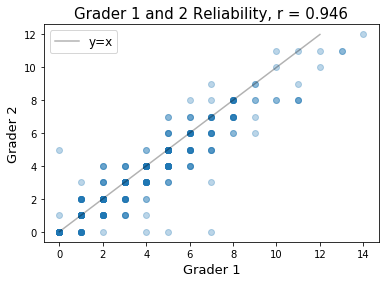

In [18]:
Grader1 = all_scores[0].ravel()
Grader2 = all_scores[1].ravel()
plt.scatter(Grader1, Grader2,alpha=0.3)
plt.plot([0,12],[0,12], label='y=x', color='black', alpha=0.3)
plt.title("Grader 1 and 2 Reliability, r = {:.3f}".format(stats.pearsonr(Grader1,Grader2)[0]),fontsize=15);
plt.xlabel("Grader 1", fontsize=13); plt.ylabel("Grader 2", fontsize=13)
plt.legend( prop={'size': 12});

## visualize subject performance

sort by best stories and best subjects, then visualize

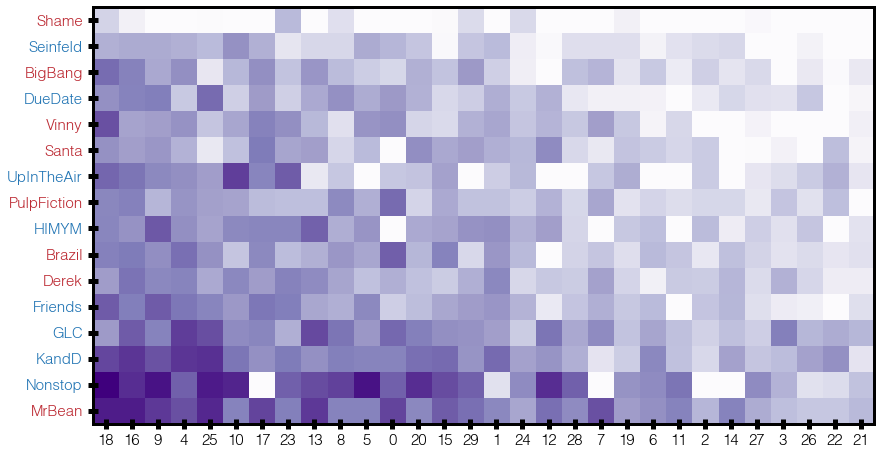

In [19]:
## sort by best stories and best subjects, then visualize

avgBestStories = np.argsort(np.mean(rubric_norm_story,axis=0))[::-1]
avgBestSubj = np.argsort(np.mean(rubric_norm_story,axis=1))[::-1]

## for coloring restaurants ticks red, and airports blue
rest = np.array([True  if sc_order[story]=='R' else False for story in avgBestStories])

# cmap = 'viridis'#'gist_yarg' #magma
# cmap = plot.Colormap('devon_r') #Ice_r #devon_r
cmap = 'Purples'
blue= "#2275b4"
red = "#bc2a33"

plt.rcParams["font.family"] = "Helvetica-Light" # set default plot font to helvetica light
fontfam = {'fontname':'Helvetica-Light'}


plt.figure(figsize=(14,8))
plt.imshow(rubric_norm_story[np.ix_(avgBestSubj,avgBestStories)].T, cmap=cmap)
plt.xticks(np.arange(30),avgBestSubj,fontsize=15,**fontfam);
plt.yticks(np.arange(16), np.array(stories)[avgBestStories],fontsize=15,**fontfam);

# plt.gca().get_xlabels(). (ax.get_xlabel(),fontsize=20,**fontfam)

for spine in ['left','right','bottom','top']:
    plt.gca().spines[spine].set_linewidth(3)
    
plt.tick_params(labelsize=15, width=5, length=10,color='black',direction='inout',pad=5)


plt.ylim(0-0.5, 16-0.5)
# plt.xlabel('Subjects', fontsize=30,labelpad=10, **fontfam)
# plt.ylabel('Stories', fontsize=30,labelpad=10,**fontfam)

for i in range(nStories):
    if rest[i]:
        plt.gca().get_yticklabels()[i].set_color(red)
    else:
        
        plt.gca().get_yticklabels()[i].set_color(blue)
        
# sns.despine(top=True, right=True, left=True, bottom=True)


plt.colorbar();
plt.tight_layout()

plt.savefig(os.path.join('figs',"rubric_results.png"), transparent=False, dpi=400)


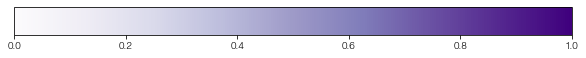

In [20]:
plt.figure(figsize=(10,5))
img = plt.imshow(np.array([[0,1]]), cmap="Purples")
plt.gca().set_visible(False)
plt.colorbar(orientation="horizontal");

In [118]:
np.sum(rubric_norm_story[stories.index("Shame")]>.05)

14

In [121]:
rubric_norm_story[stories.index("Shame")]

array([0.34375   , 0.08955224, 0.484375  , 0.24489796, 0.2875    ,
       0.28      , 0.        , 0.05813953, 0.07627119, 0.41111111,
       0.51515152, 0.5       , 0.34146341, 0.3255814 , 0.07142857,
       0.        ])

In [116]:
np.sum(rubric_norm_story[stories.index("PulpFiction")]>.50)

1

In [120]:
final_by_story[:,stories.index("Shame")]

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , 11. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  1. ,  5. ,  0. , 14.5,  5. ,  0. ,  0. ,
        0. , 20. , 13. ,  0.5,  0. ,  1.5,  0. , 12.5])

In [114]:
stories

['Brazil',
 'Derek',
 'MrBean',
 'PulpFiction',
 'BigBang',
 'Santa',
 'Shame',
 'Vinny',
 'DueDate',
 'GLC',
 'KandD',
 'Nonstop',
 'Friends',
 'HIMYM',
 'Seinfeld',
 'UpInTheAir']

## Performance by Modality or Schema 

compare by schema

Ttest_indResult(statistic=0.655651267227268, pvalue=0.5123639682384684)


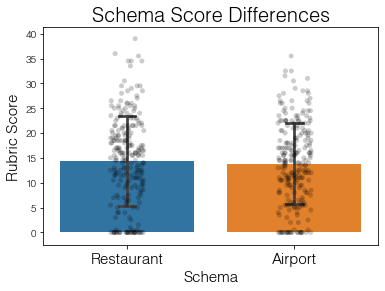

In [21]:
df = pd.DataFrame({'score': final_by_story.ravel(),
                  'schema': list(sc_order)*nSubj,
                  'modality':list(modality)*nSubj})

bar = sns.barplot(x="schema", y="score", data=df, capsize=.1, ci="sd")
sns.stripplot(x="schema", y="score", data=df,color='black',  alpha=.2);

bar.axes.set_title("Schema Score Differences",fontsize=20)
bar.set_xlabel("Schema",fontsize=15)
bar.set_ylabel("Rubric Score",fontsize=15)
bar.set_xticklabels(["Restaurant","Airport"],fontsize=15);

### test whether difference in subject scores based on schema
print(stats.ttest_ind(df.score[df.schema=='R'].values,df.score[df.schema=='A'].values))


## identify order of recall

In [22]:
grader = 'RM' #'CB'
useStory = 'PulpFiction'#'PulpFiction'

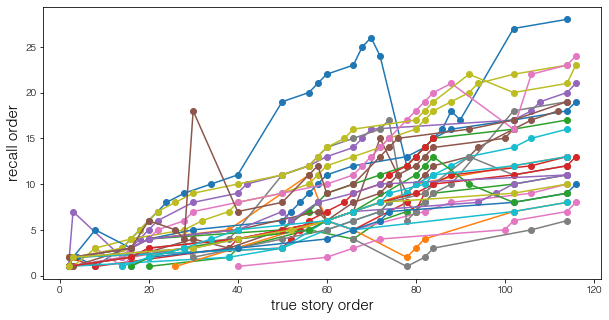

In [23]:
plt.figure(figsize=(10,5))
for subj in range(nSubj):
    rub = rubrics[grader][useStory].to_numpy()[:-1,1:][:,subj].astype(float) #ignore last row (final score) and ignore first column (description)
    idx = np.nonzero(~np.isnan(rub))[0]

    plt.plot(idx,rub[idx],'-o')#rubrics[grader][useStory]['descrip']

plt.xlabel("true story order", fontsize=15)
plt.ylabel("recall order", fontsize=15);

## fraction remembered

In [24]:
grader = 'CB' #'CB'
useStory = 'PulpFiction'#'PulpFiction'

0.03 “Think nothing of it”
0.03 nan
0.07 “Vincent”
0.07 SERVER RED: small stature server in red suit, red hat, black pants and white gloves
0.07 “what about you Peggy Sue?”
0.07 “thanks”
0.07 “thanks very much rick, good job . . . he’ll be back in the second half of our show, so i hope you enjoy your meals here at jackrabbit, slims”
0.07 nan
0.07 “why don’t you seat them over there in the Chrysler”
0.10 seated: pale turquoise chrysler is the seating table
0.10 Enter: palm trees and road as floor, racecar flags in background with  people playing motor controlled cars, there’s a billboard with a couple kissing and text: “the young racers”, Two cowboys are serving customers along the exposed brick, pale turquoise chrysler, circular stage where performances occur.
0.10 “Martin and Lewis.”
0.10 “How d'ya want that shake, Martin and Lewis, or Amos and Andy?”
0.13 nan
0.13 nan
0.13 “Ah, car”
0.13 nan
0.13 “steak steak steak steak steak”
0.20 nan
0.20 nan
0.20 nan
0.20 nan
0.27 nan
0.27 “Marti

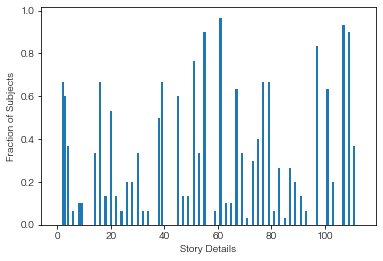

In [25]:
# Count the fraction of cells in each row are not NaN
# This is the fraction of subjects that remembered each detail
rub = rubrics[grader][useStory].to_numpy()[:-1,1:].astype(float) #ignore last row (final score) and ignore first column (description)

frac_remembered = np.sum((~np.isnan(rub)), axis=1)/nSubj

# plt.bar(np.arange(rubricMaxSubScores.sum(1)[stories.index(useStory)]), frac_remembered)
plt.bar(np.arange(rub.shape[0]), frac_remembered)

plt.xlabel('Story Details')

plt.ylabel('Fraction of Subjects')

# Sort the details by how well remembered they were
detail_order = np.argsort(frac_remembered)
for i in detail_order:
    if frac_remembered[i] > 0:
        print('%.02f' % frac_remembered[i], rubrics[grader][useStory].to_numpy()[:-1,0][i])

## visualize a specific rubric

In [26]:
grader = 'RM' #'CB'
useStory = 'PulpFiction'

/jukebox/pkgs/PYGER/0.8/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


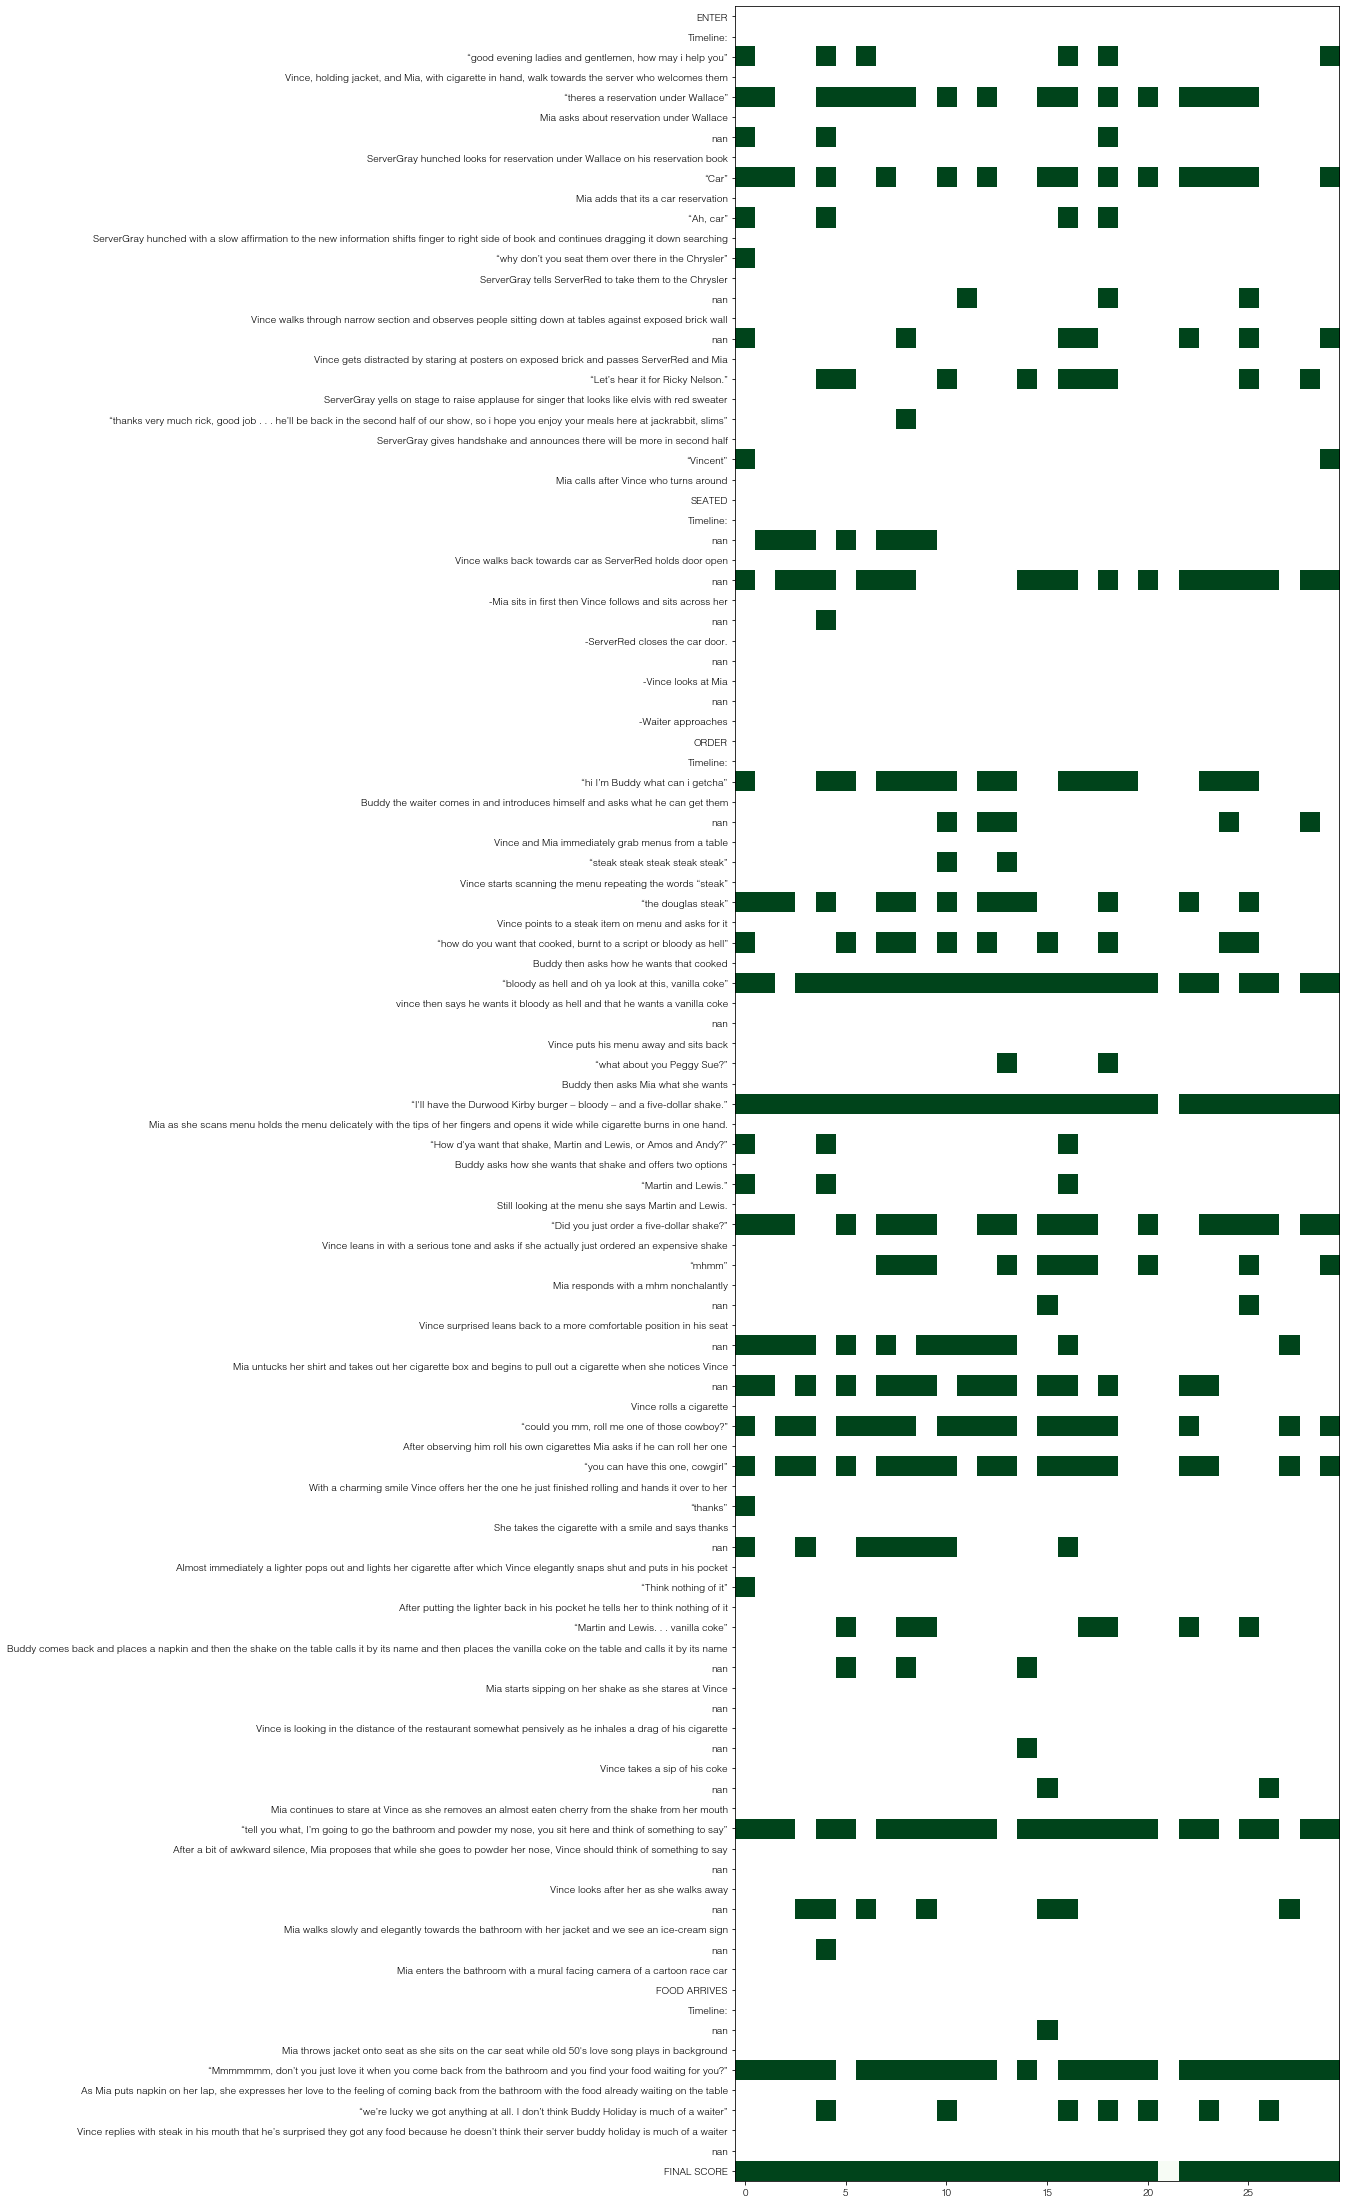

In [27]:
lines = rubrics[grader][useStory].iloc[12:,0].values
subject_performance = rubrics[grader][useStory].iloc[12:,1:].values
subject_performance[np.where(subject_performance==np.nan)]=0

subject_performance[np.where(subject_performance>0)] = 1

plt.figure(figsize=(20,40))
plt.imshow(subject_performance[::-1,:],cmap='Greens',origin='lower')
plt.yticks(np.arange(len(subject_performance)),lines[::-1])
plt.ylim(0-0.5, len(subject_performance)-0.5);